In [ ]:
import pandas as pd
import numpy as np

# Task 0
Data extraction: get the data from 3 tables & combine it into single `.csv` file.
After that read this file using pandas to create Dataframe.
So it will be all joined data in 1 dataframe. Quick check - should be 74818 rows in it.

In [1]:
import pandas as pd
import sqlite3
connection=sqlite3.connect("../db.sqlite3")
cursor=connection.cursor()
data_=pd.read_sql("SELECT restaurant_product.name, restaurant_product.price, restaurant_orderitem.quantity, restaurant_order.datetime"
                  " FROM restaurant_order "
                  "INNER JOIN restaurant_orderitem "
                  "ON restaurant_order.id=restaurant_orderitem.order_id "
                  "INNER JOIN restaurant_product "
                  "ON restaurant_product.id=restaurant_orderitem.product_id", connection)
data_.to_csv("data.csv", index=False)
cursor.close()
connection.close()
df=pd.read_csv("data.csv")
df

,name,price,quantity,datetime
0,Plain Papadum,0.80,2,2019-08-03 20:25:00
1,King Prawn Balti,12.95,1,2019-08-03 20:25:00
2,Garlic Naan,2.95,1,2019-08-03 20:25:00
3,Mushroom Rice,3.95,1,2019-08-03 20:25:00
4,Paneer Tikka Masala,8.95,1,2019-08-03 20:25:00
...,...,...,...,...
74813,House Red wine 75cl,17.95,2,2016-05-18 18:53:00
74814,House Red wine 75cl,17.95,2,2016-05-14 19:28:00
74815,House Red wine 75cl,17.95,2,2016-05-10 13:18:00
74816,House white wine 75cl,17.95,1,2016-04-07 19:04:00


# Task 1
Get Top 10 most popular products in restaurant sold by Quantity.
Count how many times each product was sold and create a pie chart with percentage of popularity (by quantity) for top 10 of them.

Example:

![pie chart](../demo/pie.png)

<Axes: title={'center': '10 top products'}>

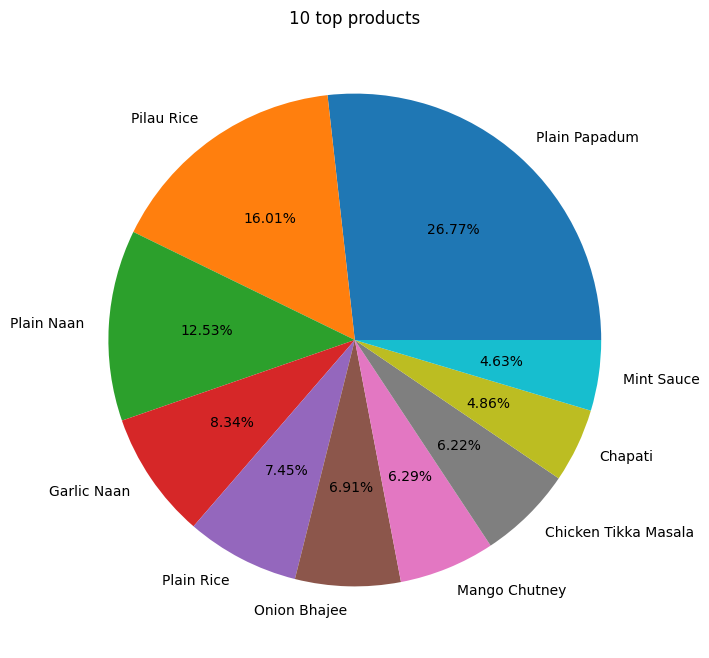

In [15]:
import matplotlib.pyplot as plt
first_10_quantity=df.groupby("name").sum("quantity").sort_values(by="quantity", ascending=False)[:10]
quantity=first_10_quantity["quantity"].sum()
first_10_quantity["percentage"]=(first_10_quantity["quantity"] * 100 / quantity).round(2)
first_10_quantity["percentage"].plot.pie(title="10 top products", figsize=(8,8), autopct='%.2f%%', ylabel="")

# Task 2
Calculate `Item Price` (Product Price * Quantity) for each Order Item in dataframe.
And Make the same Top 10 pie chart, but this time by `Item Price`. So this chart should describe not the most popular products by quantity, but which products (top 10) make the most money for restaurant. It should be also with percentage.

<Axes: title={'center': '10 top items'}>

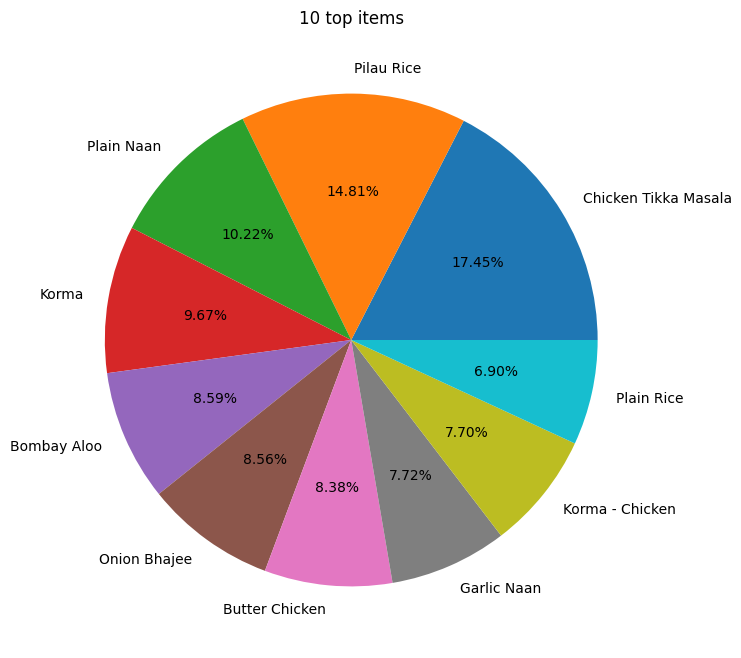

In [16]:
first_10_items=df
first_10_items["item_price"]=first_10_items["quantity"] * first_10_items["price"]
first_10_items=df.groupby("name").sum("item_price").sort_values(by="item_price", ascending=False)[:10]
first_10_items["item_price"].plot.pie(title="10 top items", figsize=(8,8), autopct='%.2f%%', ylabel="")

# Task 3
Calculate `Order Hour` based on `Order Datetime`, which will tell about the specific our the order was created (from 0 to 23). Using `Order Hour` create a bar chart, which will tell the total restaurant income based on the hour order was created. So on x-axis - it will be values from 0 to 23 (hours), on y-axis - it will be the total sum of order prices, which were sold on that hour.

Example:

![bar chart](../demo/bar.png)

<Axes: xlabel='hour', ylabel='income'>

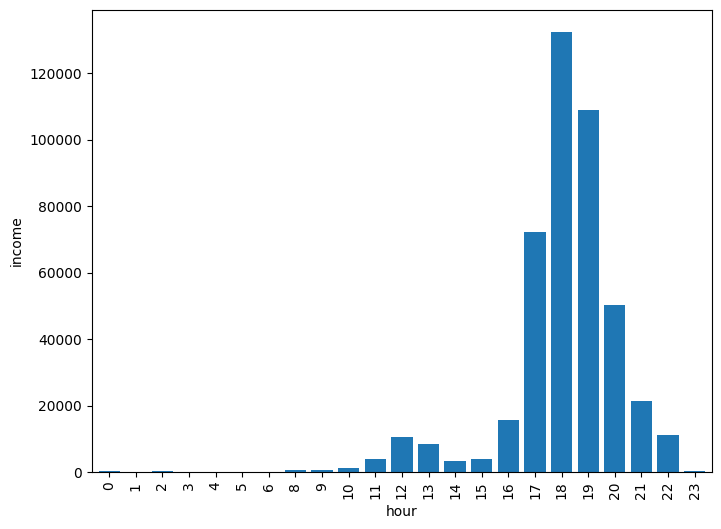

In [34]:
df["datetime"]=pd.to_datetime(df["datetime"])
df["hour"]=df["datetime"].dt.hour
data_hours= df.groupby("hour").sum("item_price").sort_values(by="hour")
data_hours.plot.bar(y="item_price", xlabel="hour", ylabel="income", width=0.8, figsize=(8, 6), legend=False)


# Task 4
Make similar bar chart, but right now with `Order Day Of The Week` (from Monday to Sunday), and also analyze total restaurant income by each day of the week.

<Axes: title={'center': 'Restaurant income per week day'}, xlabel='day_of_week', ylabel='income'>

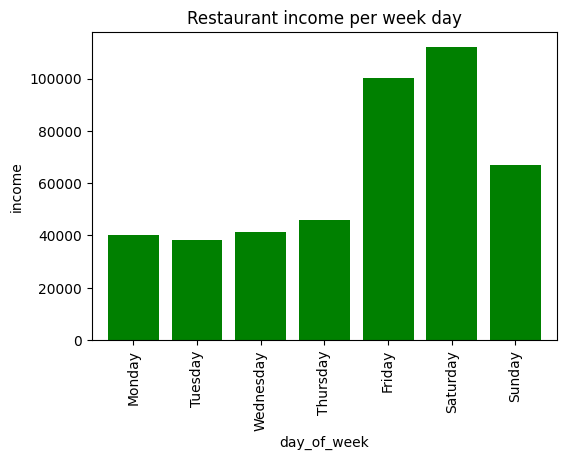

In [40]:
days_week = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
df["day_of_week"] = df["datetime"].dt.day_name()
df["day_of_week"] =pd.Categorical(df["day_of_week"], categories=days_week, ordered=True )
df = df.sort_values("day_of_week")
top_day = df.groupby("day_of_week").sum("item_price")
top_day.plot.bar(y="item_price", xlabel="day_of_week", ylabel="income", color="g", width=0.8, figsize=(6, 4),title="Restaurant income per week day" ,legend=False)